# Экспериментальная часть

In [67]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import string
from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import ConceptDriftStream
import datetime
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import gc
from itertools import product

In [26]:
count_vect = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
tfidf_vect = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
porter_stemmer = nltk.stem.PorterStemmer()
tok = count_vect.build_tokenizer()
clf = LogisticRegression(solver='lbfgs', C = 2.8, penalty = 'l1', multi_class = 'multinomial')
samples_number = 7

In [27]:
# df_all = pd.read_csv('Electronics_5.csv')
# # df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%Y-%m-%d")
# # df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all

In [28]:
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
# df_all["bin_label"] = df_all.overall > 3
# df_all["label"] = df_all.overall.apply(lambda x: '3' if x == 3 else ('1-2' if x < 3 else '4-5'))
# df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))
# df_all

In [29]:
# df_by_years = {}
# for year in df_all.reviewTime.dt.year.unique().tolist():
#     df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
#     print(year, len(df_by_years[year]))
#     print(df_by_years[year].bin_label.value_counts(), '\n')

In [30]:
# skf = StratifiedKFold(n_splits=samples_number)
# data_by_year_splitted = {}
# for year in range(2007, 2015):
#     data_tmp = df_by_years[year].sample(35000)
#     data_list, labels_list = [], []
    
#     for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
#         data = data_tmp.iloc[test_index]
#         data_list.append(data.words)
#         labels_list.append(data.label)
        
#     data_by_year_splitted[year] = {'data': data_list, 'labels': labels_list}
#     print(year)

In [37]:
def ReadData(year, index):
    data = pd.read_csv('datasets/Electronic/{0}_{1}.csv'.format(year, index), index_col=[0])['words'].astype(str)
    labels = (pd.read_csv('datasets/Electronic/{0}_{1}.csv'.format(year, index), index_col=[0])['label'])
    return data, labels

def FormTrainData(year_train, test_index, samples_number):
    train_data = pd.Series(dtype=pd.StringDtype())
    train_labels = pd.Series(dtype=int)
    for train_index in range(samples_number):
        if test_index != train_index:
            data, labels = ReadData(year_train, train_index)
            train_data = train_data.append(data)
            train_labels = train_labels.append(labels)
    return train_data, train_labels

def KLDivergence(a, b):
    tmp_a = a/sum(a)
    tmp_b = a/sum(b)
    return sum(tmp_a[i] * np.log(tmp_a[i]/tmp_b[i]) for i in range(len(tmp_a)))

In [38]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))
df_tvd = df_accuracy.copy()
df_js = df_accuracy.copy()
df_ks = df_accuracy.copy()
df_perc_no_zero = df_accuracy.copy()
df_f1_macro = df_accuracy.copy()
df_f1_micro = df_accuracy.copy()
df_f1_weighted = df_accuracy.copy()
df_f1 = df_accuracy.copy()
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [39]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))

df_tvd_lstm = df_accuracy.copy()
df_js_lstm = df_accuracy.copy()
df_ks_lstm = df_accuracy.copy()
df_kl_lstm = df_accuracy.copy()

df_tvd_tfidf = df_accuracy.copy()
df_js_tfidf = df_accuracy.copy()
df_ks_tfidf = df_accuracy.copy()
df_kl_tfidf = df_accuracy.copy()

df_tvd_count = df_accuracy.copy()
df_js_count = df_accuracy.copy()
df_ks_count = df_accuracy.copy()
df_kl_count = df_accuracy.copy()

df_tvd_prob = df_accuracy.copy()
df_js_prob = df_accuracy.copy()
df_ks_prob = df_accuracy.copy()
df_kl_prob = df_accuracy.copy()

df_tvd_Y = df_accuracy.copy()
df_js_Y = df_accuracy.copy()
df_ks_Y = df_accuracy.copy()
df_kl_Y = df_accuracy.copy()


df_perc_no_zero = df_accuracy.copy()
df_f1 = df_accuracy.copy()
measurements = {'metrics': {'f1': df_f1, 'accuracy': df_accuracy},
                'lstm': {'tvd': df_tvd_lstm, 'js': df_js_lstm, 'ks': df_ks_lstm, 'kl': df_kl_lstm},
                'tfidf': {'tvd': df_tvd_tfidf, 'js': df_js_tfidf, 'ks': df_ks_tfidf, 'kl': df_kl_tfidf},
                'count': {'tvd': df_tvd_count, 'js': df_js_count, 'ks': df_ks_count, 'kl': df_kl_count},
                'prob': {'tvd': df_tvd_prob, 'js': df_js_prob, 'ks': df_ks_prob, 'kl': df_kl_prob},
                'Y': {'tvd': df_tvd_Y, 'js': df_js_Y, 'ks': df_ks_Y, 'kl': df_kl_Y},
                'perc_no_zero': df_perc_no_zero
               }
measurements['metrics']['accuracy']
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [104]:
for year_train in range(2007, 2015):
    for test_index in range(samples_number):
        print('01_initialization')
        vecotrizer_tfidf = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        vecotrizer_count = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        
        print('\n02_Build_train_data')
        train_data, train_labels = FormTrainData(year_train, test_index, samples_number)
        train_labels = train_labels.apply(lambda x: 1 if x == 3 else (0 if x < 3 else 2))
        
        print('\n03_Data_Vectorization')
        
        train_data_count = vecotrizer_count.fit_transform(train_data)
        joblib.dump(vecotrizer_count, 'vecotrizer_count.pkl')
        joblib.dump(train_data_count, 'train_data_count.pkl')
        del vecotrizer_count
        del train_data_count
        
        train_data_tfidf = vecotrizer_tfidf.fit_transform(train_data)
        train_data = train_data_tfidf.copy()
        joblib.dump(vecotrizer_tfidf, 'vecotrizer_tfidf.pkl')
        joblib.dump(train_data_tfidf, 'train_data_tfidf.pkl')
        del vecotrizer_tfidf
        del train_data_tfidf
        
#         class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
        gc.collect()
        
        
        print('\n05_Build_model')
        model = LogisticRegression(solver='liblinear', C = 2.8, penalty = 'l1', class_weight='balanced')
        
        print('\n06_Fit_model')
        
        model.fit(train_data, train_labels)
        
        print('\n07_Test_years')
        
        train_data_tfidf = joblib.load('train_data_tfidf.pkl')
        train_data_count = joblib.load('train_data_count.pkl')
        tfidf_dist_train = np.array(np.mean(train_data_tfidf, axis = 0))[0,:]
        count_dist_train = np.array(np.mean(train_data_count, axis = 0))[0,:]
        prob_dist_train = np.unique(np.round(model.predict_proba(train_data), 2), return_counts=True)[1]
        Y_dist_train = np.mean(model.predict_proba(train_data), axis = 0)
        
        del train_data_tfidf
        del train_data_count
        
        for year_test in range(year_train, 2015):
            
            test_data, test_labels = ReadData(year_test, test_index)
            test_labels = test_labels.apply(lambda x: 1 if x == 3 else (0 if x < 3 else 2))
            
            vecotrizer_tfidf = joblib.load('vecotrizer_tfidf.pkl')
            tfidf_dist_test = np.array(np.mean(vecotrizer_tfidf.transform(test_data), axis = 0))[0,:]
            
            vecotrizer_count = joblib.load('vecotrizer_count.pkl')
            count_dist_test = np.array(np.mean(vecotrizer_count.transform(test_data), axis = 0))[0,:]
            del vecotrizer_count
            test_data = vecotrizer_tfidf.transform(test_data)
            del vecotrizer_tfidf
            
            prob_dist_test = np.unique(np.round(model.predict_proba(test_data), 2), return_counts=True)[1]
            Y_dist_test = np.mean(model.predict_proba(test_data), axis = 0)

            
            accuracy = accuracy_score(model.predict(test_data),test_labels)
            y_pred = model.predict(test_data)
            fbeta_score = f1_score(y_pred, test_labels, average='macro')
            df_f1.loc[year_train][year_test][test_index] = fbeta_score
            df_accuracy.loc[year_train][year_test][test_index] = accuracy
           
            
            df_tvd_tfidf.loc[year_train][year_test][test_index] = sum(abs(tfidf_dist_train - tfidf_dist_test))/2
            df_js_tfidf.loc[year_train][year_test][test_index] = jensenshannon(tfidf_dist_train, tfidf_dist_test)
            df_ks_tfidf.loc[year_train][year_test][test_index] = ks_2samp(tfidf_dist_train, tfidf_dist_test).statistic
            df_kl_tfidf.loc[year_train][year_test][test_index] = KLDivergence(tfidf_dist_train, tfidf_dist_test)
            
            df_tvd_count.loc[year_train][year_test][test_index] = sum(abs(count_dist_train - count_dist_test))/2
            df_js_count.loc[year_train][year_test][test_index] = jensenshannon(count_dist_train, count_dist_test)
            df_ks_count.loc[year_train][year_test][test_index] = ks_2samp(count_dist_train, count_dist_test).statistic
            df_kl_count.loc[year_train][year_test][test_index] = KLDivergence(count_dist_train, count_dist_test)
            
            try:
                df_tvd_prob.loc[year_train][year_test][test_index] = sum(abs(prob_dist_train - prob_dist_test))/2
                df_js_prob.loc[year_train][year_test][test_index] = jensenshannon(prob_dist_train, prob_dist_test)
                df_ks_prob.loc[year_train][year_test][test_index] = ks_2samp(prob_dist_train, prob_dist_test).statistic
                df_kl_prob.loc[year_train][year_test][test_index] = KLDivergence(prob_dist_train, prob_dist_test)
            except:
                print('Error count prob')
            
            df_tvd_Y.loc[year_train][year_test][test_index] = sum(abs(Y_dist_train - Y_dist_test))/2
            df_js_Y.loc[year_train][year_test][test_index] = jensenshannon(Y_dist_train, Y_dist_test)
            df_ks_Y.loc[year_train][year_test][test_index] = ks_2samp(Y_dist_train, Y_dist_test).statistic
            df_kl_Y.loc[year_train][year_test][test_index] = KLDivergence(Y_dist_train, Y_dist_test)
                        
            df_perc_no_zero.loc[year_train][year_test][test_index] = np.count_nonzero(count_dist_test)/np.count_nonzero(count_dist_train)            
            
            print("Train in {0}, test in {1}, test sample {2}\nf1_score = {3}\naccuracy = {4}".format(year_train, year_test, test_index, fbeta_score, accuracy))
            print('\nConfusion Matrix')
            print(confusion_matrix(test_labels, y_pred))
            print('\nClassification Report')
            print(classification_report(test_labels, y_pred))
            del test_data
            del test_labels
#             del loss
            del accuracy
            gc.collect()
        
        print('step 8')
#         clear_session()
        del model
        del train_data
        del train_labels
#         del gen
        gc.collect()

01_initialization

02_Build_train_data

03_Data_Vectorization

05_Build_model

06_Fit_model

07_Test_years
Train in 2007, test in 2007, test sample 0
f1_score = 0.6162837901221748
accuracy = 0.8376

Confusion Matrix
[[ 436   61  134]
 [ 132  102  185]
 [ 133  167 3650]]

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       631
           1       0.31      0.24      0.27       419
           2       0.92      0.92      0.92      3950

    accuracy                           0.84      5000
   macro avg       0.62      0.62      0.62      5000
weighted avg       0.83      0.84      0.83      5000

Train in 2007, test in 2008, test sample 0
f1_score = 0.6307154340706438
accuracy = 0.849

Confusion Matrix
[[ 427   68  120]
 [ 111  107  206]
 [ 122  128 3711]]

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       615
           1       0.35      0

In [27]:
# for year_train in range(2007, 2015):
#     for test_index in range(samples_number):
#         vecotrizer = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
#         clf = LogisticRegression(solver='liblinear', C = 2.8, penalty = 'l1', class_weight='balanced')
#         train_data, train_labels = FormTrainData(year_train, test_index, samples_number)
        
#         train_labels = train_labels.apply(lambda x: 1 if x == 3 else (0 if x < 3 else 2))
        
#         train_data = vecotrizer.fit_transform(train_data)
#         clf.fit(train_data, train_labels)
#         for year_test in range(year_train, 2015):
                        
#             test_data, test_labels = ReadData(year_test, test_index)
            
#             test_labels = test_labels.apply(lambda x: 1 if x == 3 else (0 if x < 3 else 2))
            
#             test_data = vecotrizer.transform(test_data)
#             y_pred = clf.predict(test_data)
#             df_accuracy.loc[year_train][year_test][test_index] = accuracy_score(clf.predict(test_data),test_labels)
#             df_f1_macro.loc[year_train][year_test][test_index] = f1_score(y_pred,test_labels, average='macro')
#             df_f1_micro.loc[year_train][year_test][test_index] = f1_score(y_pred,test_labels, average='micro')
#             df_f1_weighted.loc[year_train][year_test][test_index] = f1_score(y_pred,test_labels, average='weighted')
            
#             dist_train = np.array(train_data.mean(axis=0))[0]
#             dist_test = np.array(test_data.mean(axis=0))[0]
#             tvd = sum(abs(dist_train - dist_test))/2
#             js = jensenshannon(dist_train, dist_test)
#             ks = ks_2samp(dist_train, dist_test).statistic
#             perc_no_zero = np.count_nonzero(dist_test)/np.count_nonzero(dist_train)
#             df_tvd.loc[year_train][year_test][test_index] = tvd
#             df_js.loc[year_train][year_test][test_index] = js
#             df_ks.loc[year_train][year_test][test_index] = ks
#             df_perc_no_zero.loc[year_train][year_test][test_index] = perc_no_zero
#             print("Train in {0}, test in {1}, test sample {2}\naccuracy_score = {3}, TVD = {4}, JS = {5}, KS = {6}, F1 = {7}".format(year_train, year_test, test_index, df_accuracy.loc[year_train][year_test][test_index], tvd, js, ks, df_f1_weighted.loc[year_train][year_test][test_index]))
# #             print('\nConfusion Matrix')
# #             print(confusion_matrix(test_labels, y_pred))
# #             print('\nClassification Report')
# #             print(classification_report(test_labels, y_pred))
# # df_accuracy = df_accuracy/samples_number
# # df_accuracy[df_accuracy.eq(0)] = np.nan

Train in 2007, test in 2007, test sample 0
accuracy_score = 0.8376, TVD = 1.5150201410277253, JS = 0.15986785122517078, KS = 0.21712538226299694, F1 = 0.8415100343130627
Train in 2007, test in 2008, test sample 0
accuracy_score = 0.849, TVD = 1.6064394336709142, JS = 0.1614718874714633, KS = 0.2148261411258353, F1 = 0.8555050201526027
Train in 2007, test in 2009, test sample 0
accuracy_score = 0.839, TVD = 1.7396219066529042, JS = 0.1663234391964565, KS = 0.21642315097972592, F1 = 0.847576576386773
Train in 2007, test in 2010, test sample 0
accuracy_score = 0.826, TVD = 1.8657772825823706, JS = 0.18126924519331916, KS = 0.23489636425416244, F1 = 0.8322220321099383
Train in 2007, test in 2011, test sample 0
accuracy_score = 0.8326, TVD = 2.040876955687813, JS = 0.19913831656878245, KS = 0.2616717635066259, F1 = 0.8382462493710946
Train in 2007, test in 2012, test sample 0
accuracy_score = 0.8418, TVD = 2.2471423959548638, JS = 0.2231531654947866, KS = 0.3109865216898856, F1 = 0.84659620

In [54]:
def df_mean_values(df_values):
    df_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

    for year_train in range(2007, 2015):
        for year_test in range(year_train, 2015):
            df_mean.loc[year_train][year_test] = df_values.loc[year_train][year_test].mean()
    
    max_val = df_mean.values.max()
    df_mean[df_mean.eq(0)] = np.nan
    df_mean = max_val - df_mean
    ur_style = (df_mean
                .style
                .background_gradient(cmap='Greens', axis=0)
                .highlight_null('white')
                .format("{:.3}", na_rep=""))
    return(ur_style)

In [55]:
df_f1

2007                                                            \
             0         1         2         3        4         5        6   
2007  0.616493  0.611107  0.600864  0.602999  0.62384  0.606977  0.60581   
2008  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2009  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2010  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2011  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2012  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2013  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2014  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   

          2008                      ...      2013                      \
             0         1         2  ...         4         5         6   
2007  0.630715  0.609817  0.601621  ...  0.603839  0.604090  0.607958   
2008  0.625400  0.617499  0.614560  ...  0.599256  0.606355  0.626205   
2009  0.000000  0.000000  0.000000  ...  0.613073  0.601202  0.626623   
2010  0.000000  0.000000  0.000000  ...  0.617891  0.606465  0.604739   
2011  0.000000  0.000000  0.000000  ...  0.609986  0.618587  0.619265   
2012  0.000000  0.000000  0.000000  ...  0.611583  0.613078  0.614897   
2013  0.000000  0.000000  0.000000  ...  0.609634  0.617992  0.613572   
2014  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

          2014                                                              
             0         1         2         3         4         5         6  
2007  0.621504  0.602035  0.607764  0.632417  0.610064  0.614201  0.599907  
2008  0.602009  0.597356  0.611530  0.606451  0.620744  0.599507  0.612951  
2009  0.606497  0.611129  0.625421  0.609606  0.621186  0.610346  0.616490  
2010  0.614747  0.613612  0.602015  0.613087  0.602368  0.599738  0.602682  
2011  0.620528  0.595477  0.605406  0.618438  0.625493  0.620684  0.623283  
2012  0.608305  0.612999  0.624239  0.622421  0.628744  0.622639  0.624113  
2013  0.621952  0.612567  0.618289  0.635214  0.598729  0.609433  0.620060  
2014  0.619817  0.622799  0.611107  0.620674  0.619429  0.619117  0.623373  

[8 rows x 56 columns]

In [56]:
df_f1_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_f1_mean.loc[year_train][year_test] = df_f1.loc[year_train][year_test].mean()

df_f1_mean[df_f1_mean.eq(0)] = np.nan
ur_style = (df_f1_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style


,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.61,0.611,0.619,0.614,0.619,0.619,0.611,0.613
2008,,0.62,0.624,0.616,0.62,0.62,0.607,0.607
2009,,,0.624,0.613,0.623,0.623,0.611,0.614
2010,,,,0.621,0.622,0.621,0.608,0.607
2011,,,,,0.625,0.625,0.617,0.616
2012,,,,,,0.624,0.616,0.62
2013,,,,,,,0.616,0.617
2014,,,,,,,,0.619


In [57]:
df_accuracy_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_accuracy_mean.loc[year_train][year_test] = df_accuracy.loc[year_train][year_test].mean()

df_accuracy_mean[df_accuracy_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,83.75%,83.86%,83.55%,82.98%,83.19%,84.13%,84.81%,85.15%
2008,,83.97%,83.57%,82.88%,83.18%,84.12%,84.64%,85.09%
2009,,,83.65%,82.83%,83.31%,84.41%,84.97%,85.27%
2010,,,,83.04%,83.36%,84.33%,84.95%,85.13%
2011,,,,,83.37%,84.41%,85.16%,85.42%
2012,,,,,,84.29%,85.05%,85.47%
2013,,,,,,,84.75%,84.94%
2014,,,,,,,,85.13%


In [64]:
df_mean_values(df_tvd_count)

,2007,2008,2009,2010,2011,2012,2013,2014
2007,54.5,50.2,43.9,44.7,44.6,37.1,19.5,15.0
2008,,53.0,49.3,48.9,44.6,32.0,11.9,7.12
2009,,,51.9,49.2,41.9,26.7,4.99,0.0
2010,,,,53.1,48.5,34.0,12.2,7.16
2011,,,,,54.7,44.1,22.8,17.9
2012,,,,,,57.7,41.7,37.0
2013,,,,,,,62.1,60.4
2014,,,,,,,,63.1


In [65]:
def transform_df_to_arr(df):
    arr = df.to_numpy().reshape(7*8*8,)
    arr = arr[arr != 0]
    return(arr)

def search_correlation_old(df_1, df_2):
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.scatter(arr_1, arr_2)
    plt.show()
    return(np.corrcoef(arr_1, arr_2)[0, 1])

def search_correlation(acc_metric, data_type, dis_metric):
    df_1 = measurements[data_type][dis_metric]
    df_2 = measurements['metrics'][acc_metric]
    arr_1 = transform_df_to_arr(df_1)
    arr_2 = transform_df_to_arr(df_2)
    plt.title(data_type)
    plt.xlabel(dis_metric)
    plt.ylabel(acc_metric)
    plt.scatter(arr_1, arr_2)
    plt.show()
    return (np.corrcoef(arr_1, arr_2)[0, 1])


### Эксперимент 1

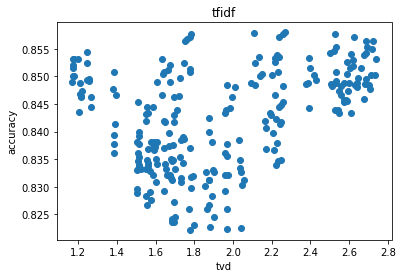

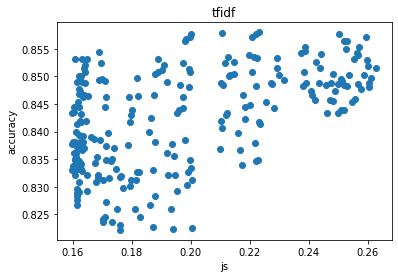

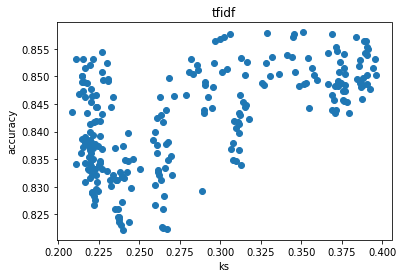

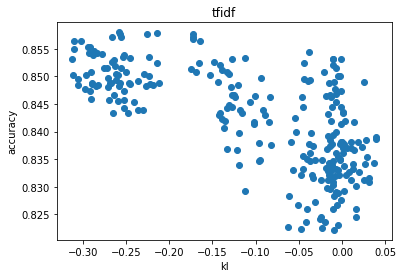

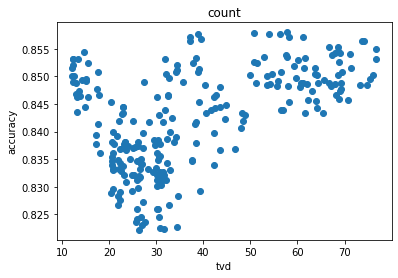

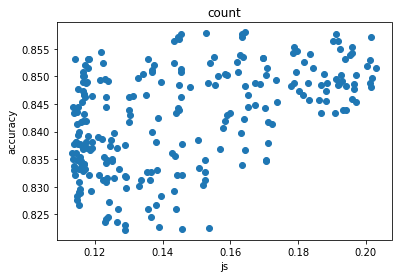

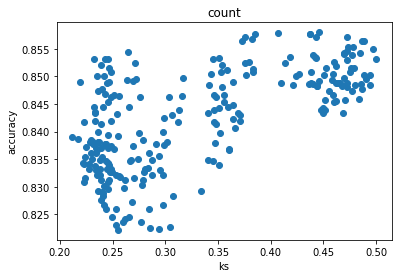

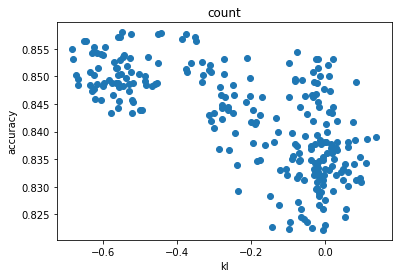

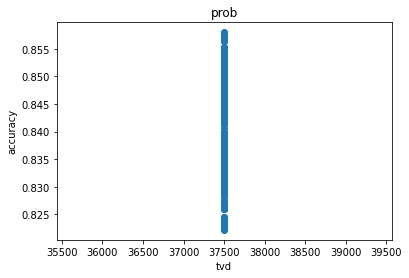

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


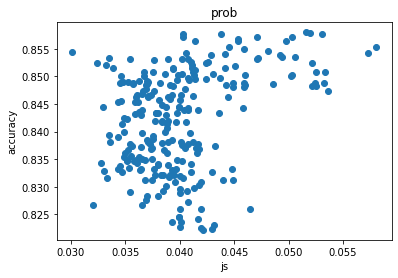

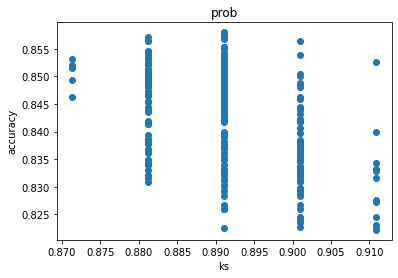

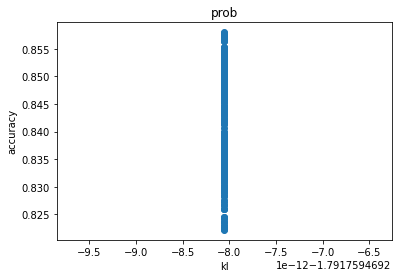

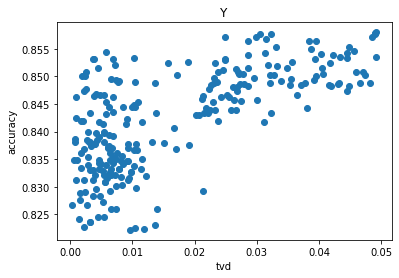

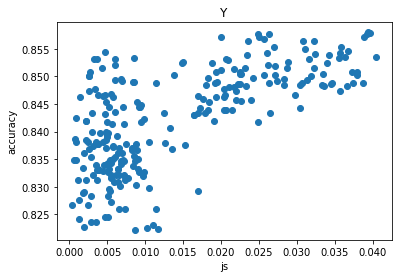

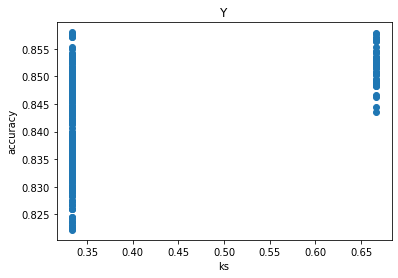

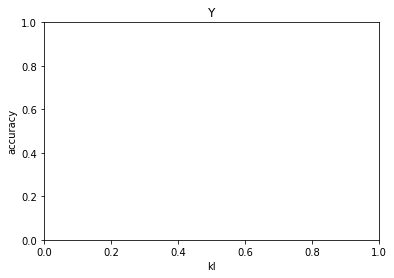

In [68]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [71]:
df_acc_corr
ur_style_acc_1 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_acc_1

,tvd,js,ks,kl
lstm,0.000%,0.000%,0.000%,0.000%
tfidf,34.928%,52.599%,58.402%,-67.441%
count,50.611%,49.406%,64.105%,-67.230%
prob,0.000%,34.462%,-43.203%,4.668%
Y,67.698%,67.587%,45.807%,0.000%


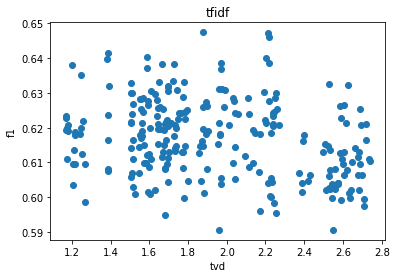

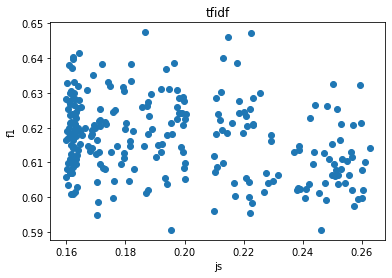

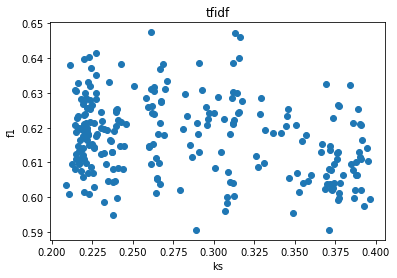

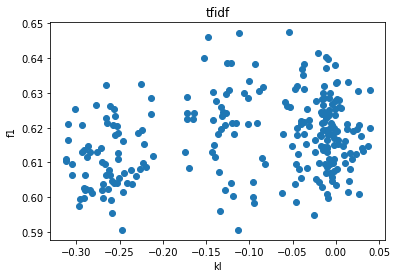

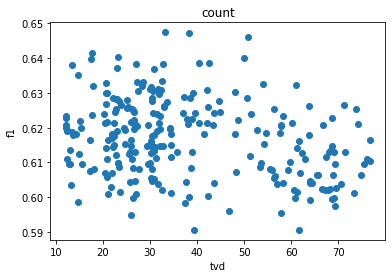

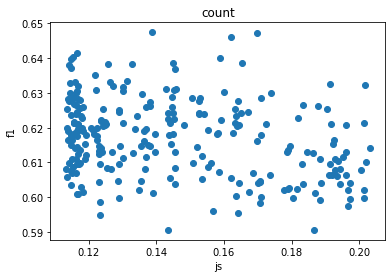

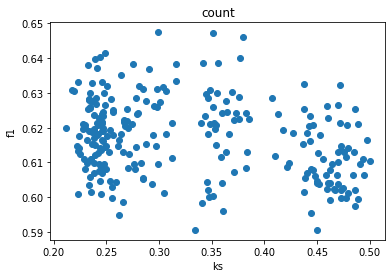

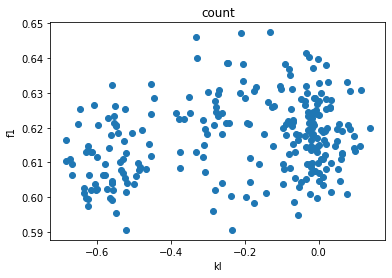

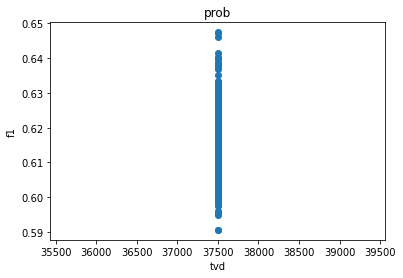

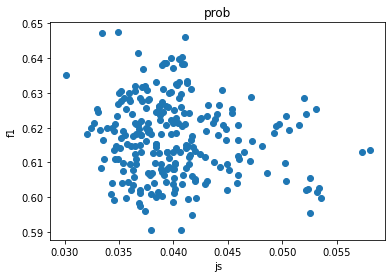

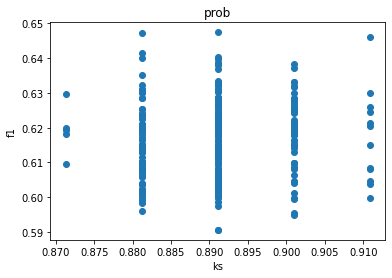

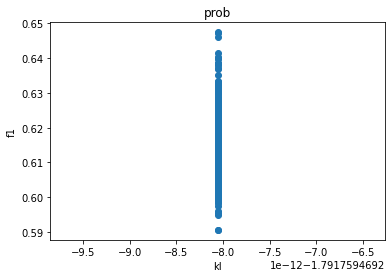

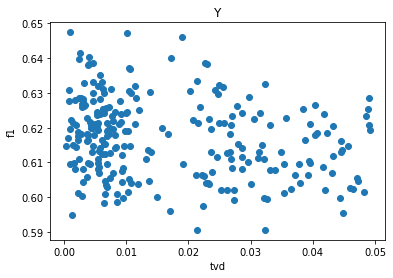

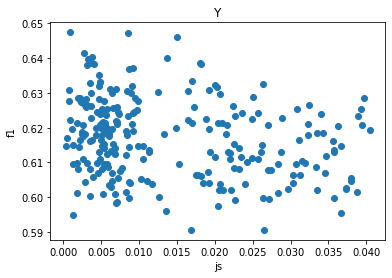

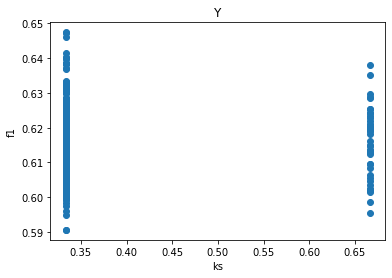

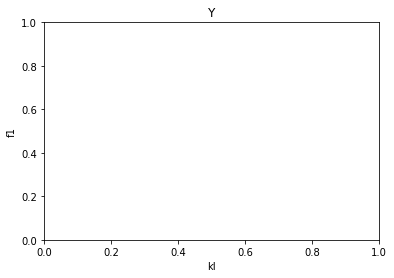

In [72]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [73]:
ur_style_f1_1 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_f1_1

,tvd,js,ks,kl
lstm,0.000%,0.000%,0.000%,0.000%
tfidf,-26.081%,-27.415%,-26.784%,26.407%
count,-27.372%,-27.376%,-26.865%,26.423%
prob,0.000%,-13.988%,5.151%,3.439%
Y,-24.077%,-24.610%,-5.026%,0.000%


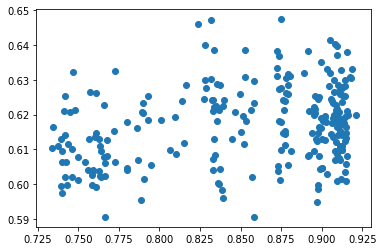

0.28387881243243435

In [74]:
search_correlation_old(df_perc_no_zero, df_f1)

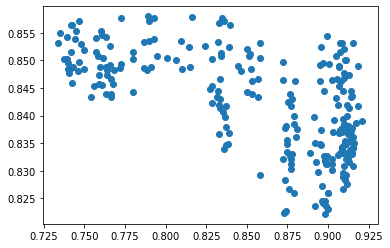

-0.6073132248644181

In [75]:
search_correlation_old(df_perc_no_zero, df_accuracy)

### Эксперимент 2

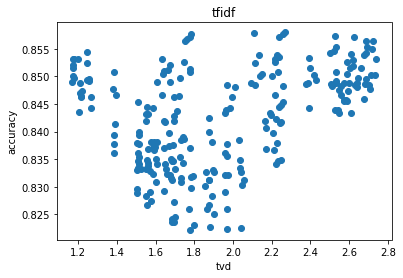

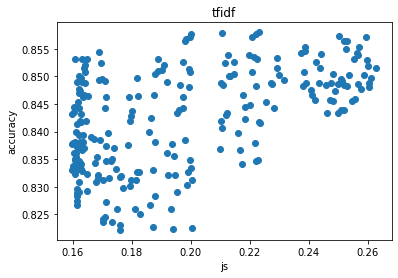

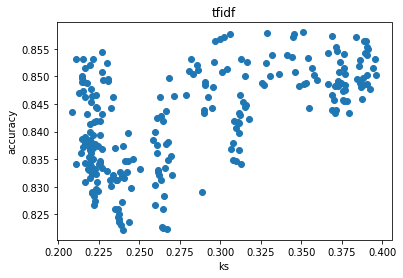

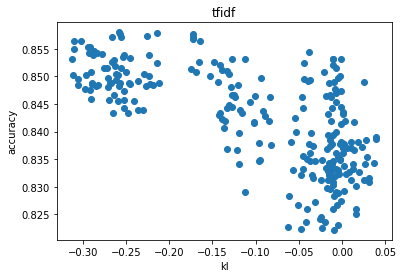

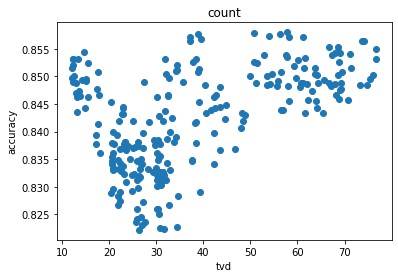

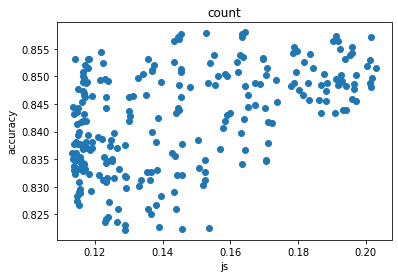

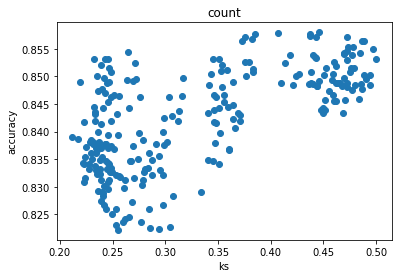

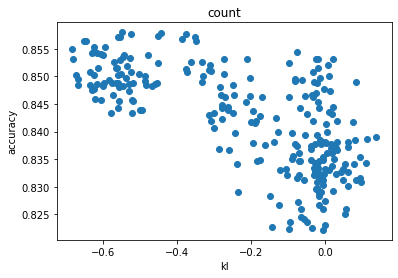

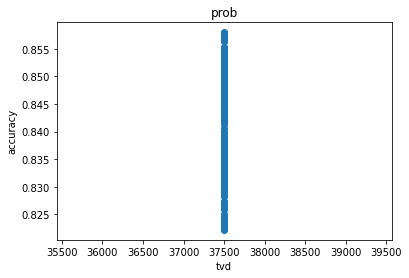

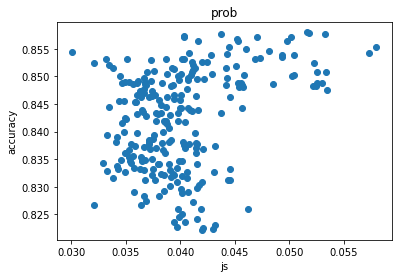

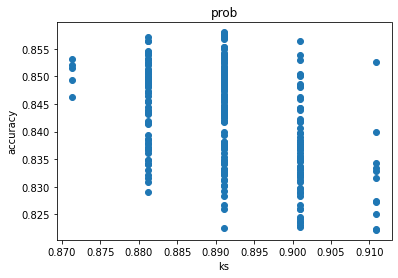

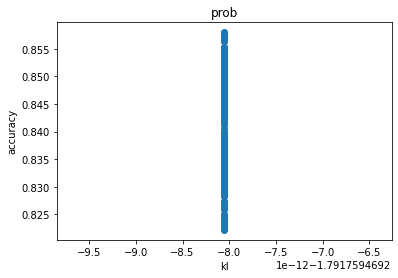

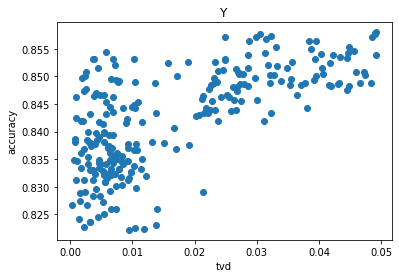

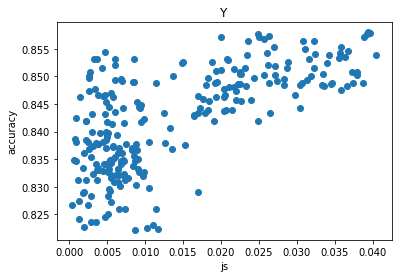

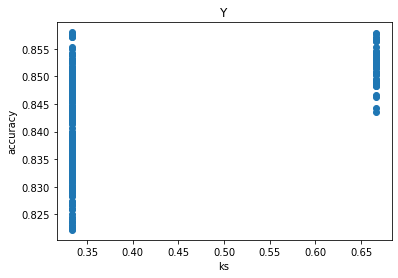

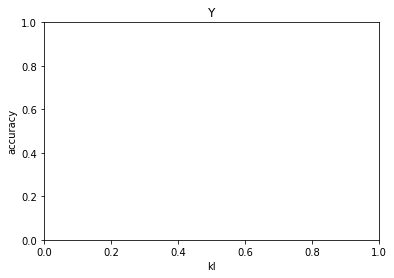

In [90]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [93]:
df_acc_corr
ur_style_acc_2 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_acc_2

,tvd,js,ks,kl
lstm,0.000%,0.000%,0.000%,0.000%
tfidf,34.967%,52.645%,58.448%,-67.488%
count,50.659%,49.451%,64.157%,-67.281%
prob,0.000%,34.162%,-41.540%,-8.260%
Y,67.757%,67.649%,45.818%,0.000%


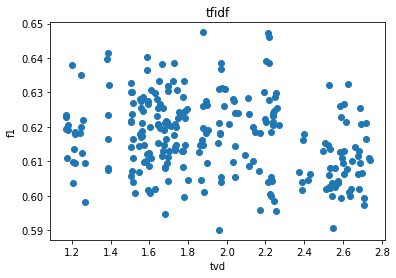

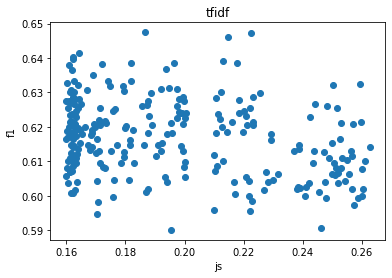

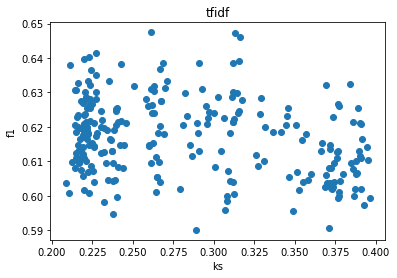

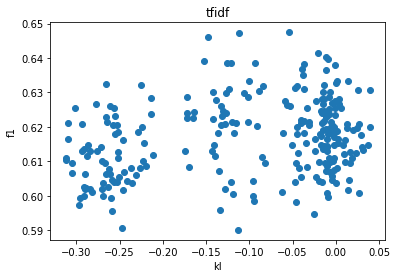

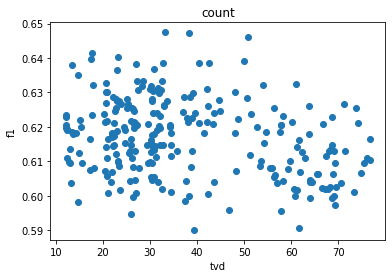

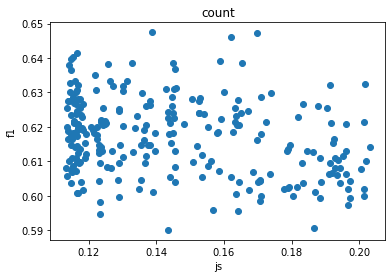

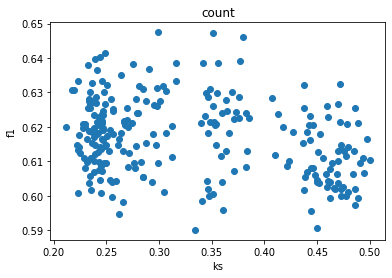

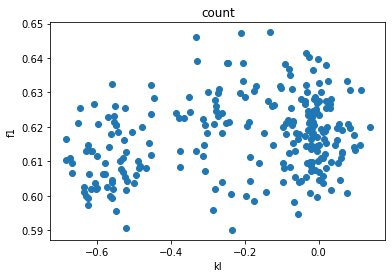

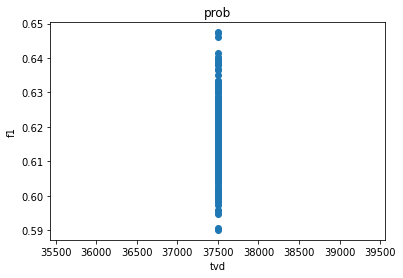

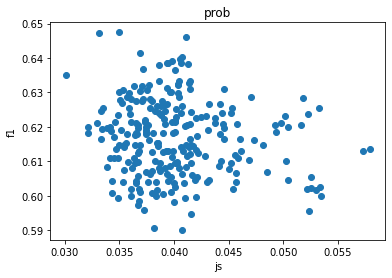

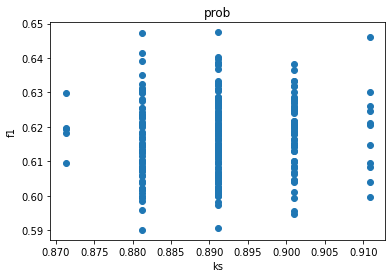

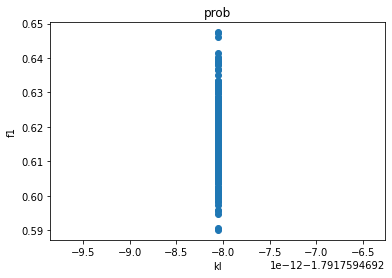

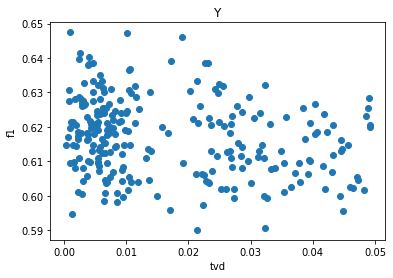

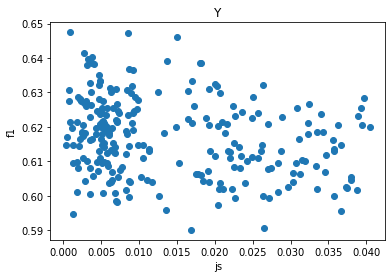

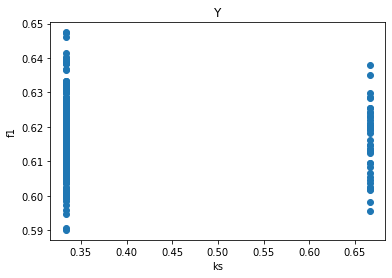

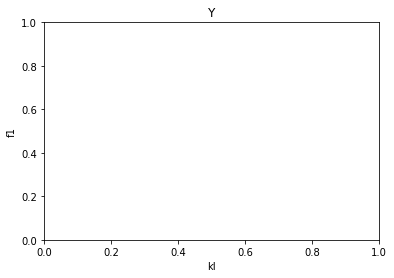

In [94]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [95]:
ur_style_f1_2 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_f1_2

,tvd,js,ks,kl
lstm,0.000%,0.000%,0.000%,0.000%
tfidf,-26.155%,-27.487%,-26.854%,26.471%
count,-27.435%,-27.448%,-26.922%,26.477%
prob,0.000%,-13.813%,7.215%,-10.320%
Y,-24.099%,-24.623%,-5.019%,0.000%


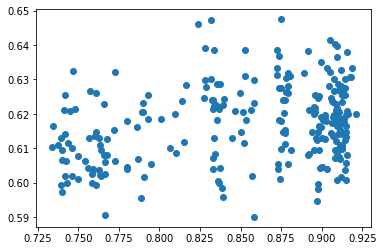

0.28451471360923275

In [96]:
search_correlation_old(df_perc_no_zero, df_f1)

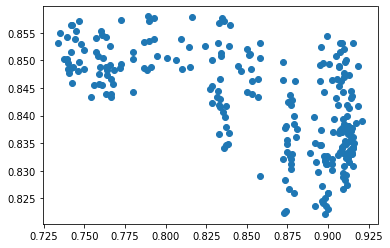

-0.607810533948768

In [97]:
search_correlation_old(df_perc_no_zero, df_accuracy)

### Эксперимент 3

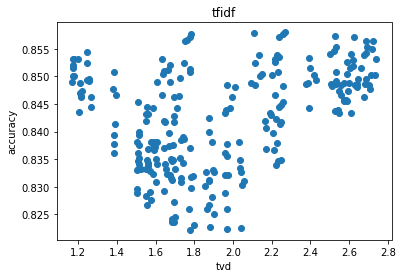

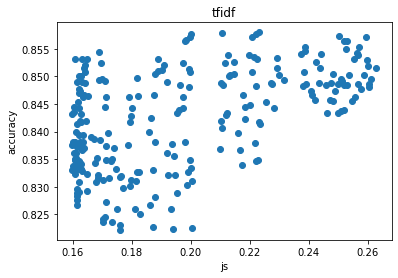

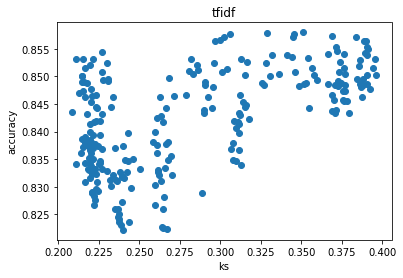

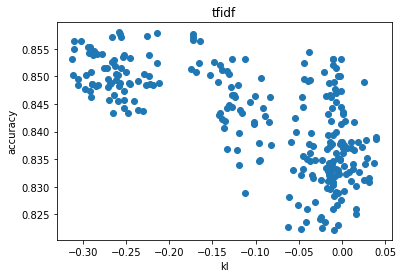

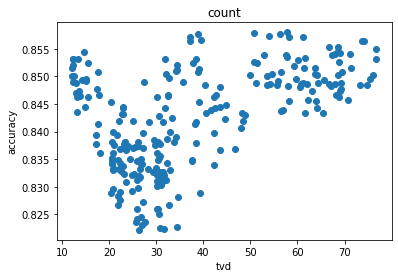

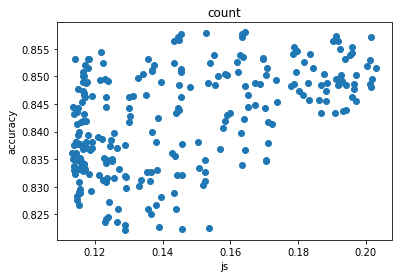

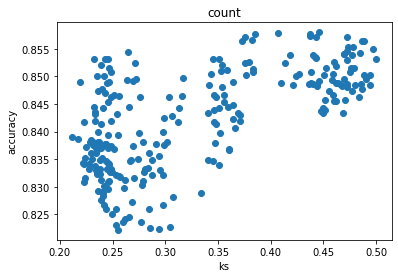

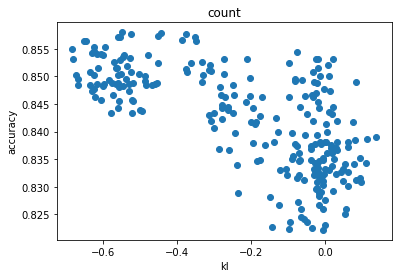

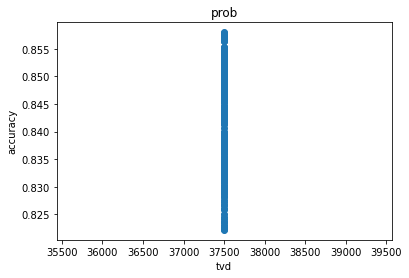

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


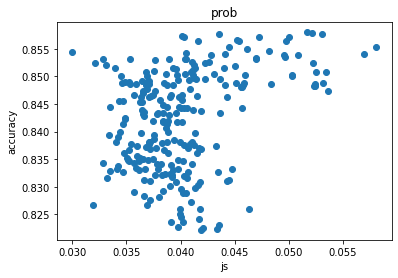

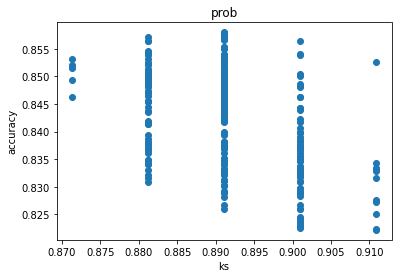

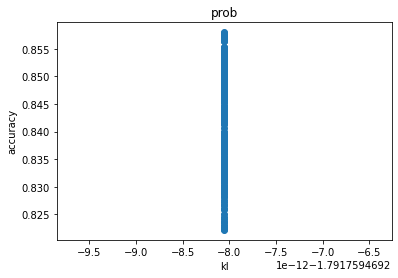

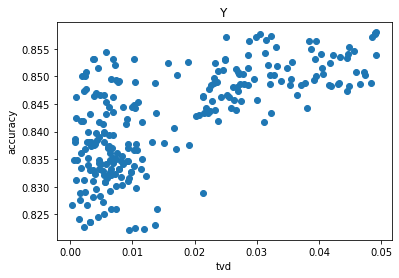

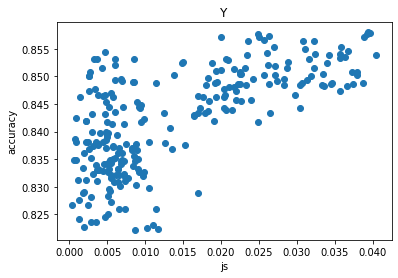

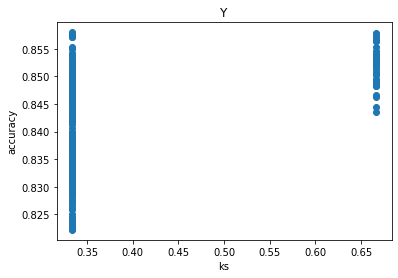

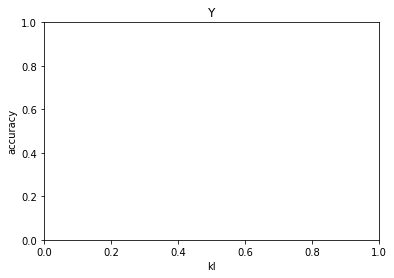

In [105]:
df_acc_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('accuracy', data_type, dis_metric)
    except:
        corr = np.nan
    df_acc_corr.loc[data_type][dis_metric] = corr

In [106]:
df_acc_corr
ur_style_acc_3 = (df_acc_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_acc_3

,tvd,js,ks,kl
lstm,0.000%,0.000%,0.000%,0.000%
tfidf,34.882%,52.564%,58.377%,-67.430%
count,50.588%,49.367%,64.092%,-67.227%
prob,0.000%,34.135%,-43.110%,-1.833%
Y,67.693%,67.587%,45.796%,0.000%


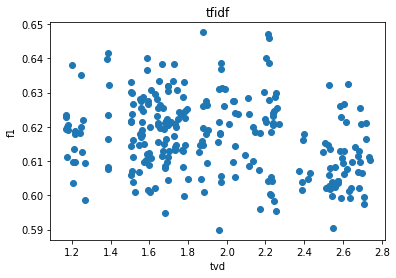

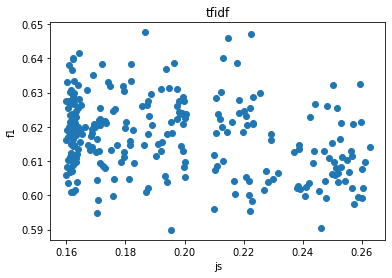

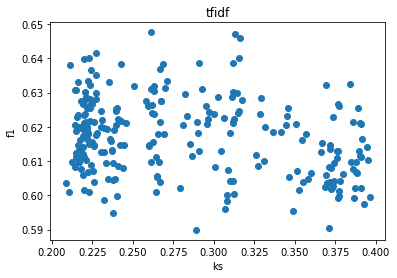

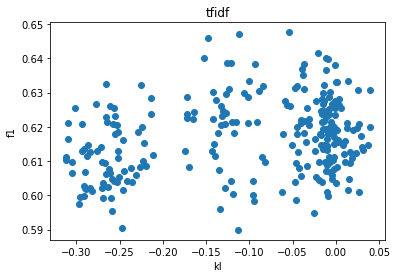

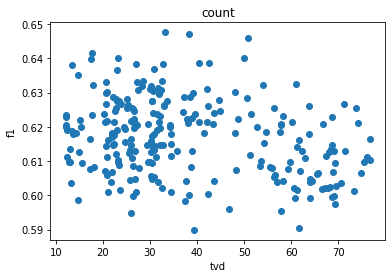

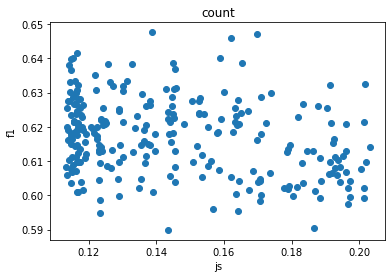

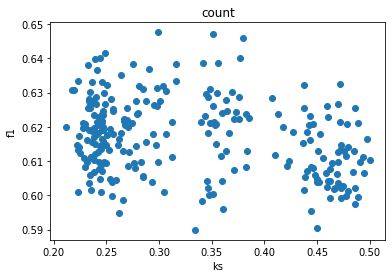

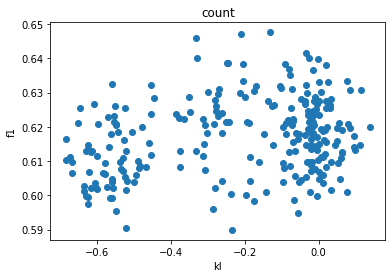

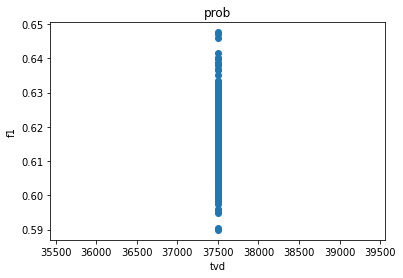

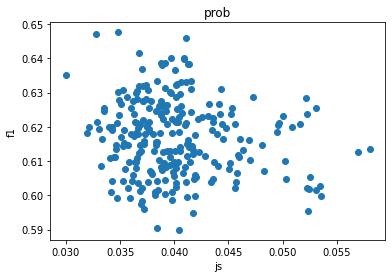

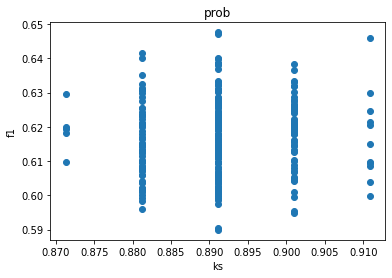

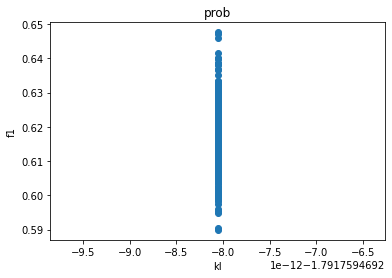

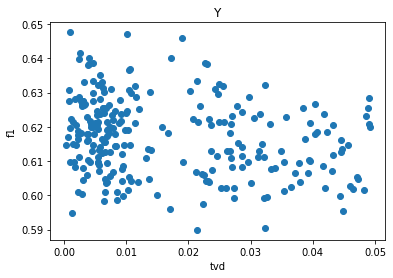

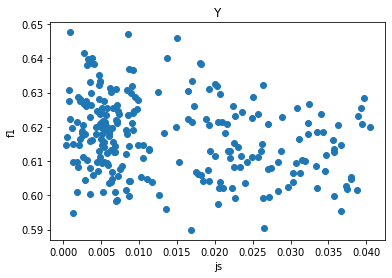

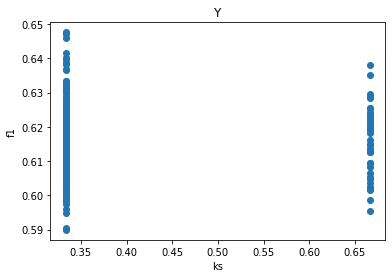

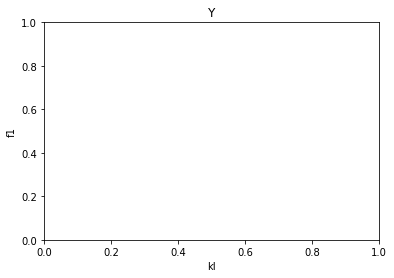

In [107]:
df_f1_corr = pd.DataFrame(index = ['lstm', 'tfidf', 'count', 'prob', 'Y'], columns=['tvd', 'js', 'ks', 'kl'])
for data_type, dis_metric in product(['lstm', 'tfidf', 'count', 'prob', 'Y'],
                                                 ['tvd', 'js', 'ks', 'kl']):
    try:
        corr = search_correlation('f1', data_type, dis_metric)
    except:
        corr = np.nan
    df_f1_corr.loc[data_type][dis_metric] = corr

In [108]:
ur_style_f1_3 = (df_f1_corr.fillna(0)
            .style
            .background_gradient(cmap='seismic', axis = None, vmin = -1, vmax = 1)
            .highlight_null('white')
            .format("{:.3%}", na_rep=""))
ur_style_f1_3

,tvd,js,ks,kl
lstm,0.000%,0.000%,0.000%,0.000%
tfidf,-26.248%,-27.576%,-26.921%,26.518%
count,-27.499%,-27.545%,-26.978%,26.517%
prob,0.000%,-14.185%,5.781%,9.104%
Y,-24.159%,-24.685%,-5.078%,0.000%


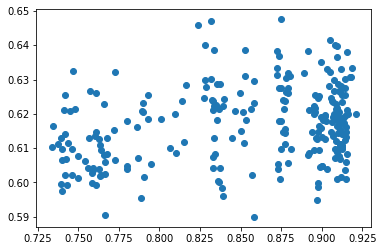

0.2852244699365026

In [109]:
search_correlation_old(df_perc_no_zero, df_f1)

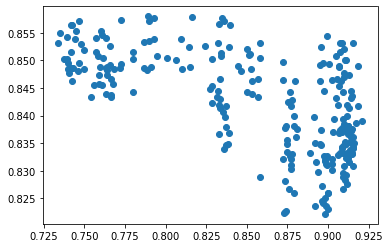

-0.6071187950835931

In [110]:
search_correlation_old(df_perc_no_zero, df_accuracy)